In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [2]:
df = pd.read_csv('GoldPrice.csv')

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [5]:
df.drop(['Vol.','Change %'], axis = 1, inplace = True)


In [6]:
df

,Date,Price,Open,High,Low
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80"
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20"
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20"
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00"
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55"
...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80"
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30"
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00"
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30"


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
NumCols = df.columns.drop('Date')
df[NumCols] = df[NumCols].replace(',', '', regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [9]:
df.head(10)

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8
5,2013-01-09,1656.5,1660.7,1664.2,1652.3
6,2013-01-10,1679.0,1656.7,1679.2,1656.7
7,2013-01-11,1661.6,1674.8,1675.7,1655.0
8,2013-01-14,1670.4,1662.3,1675.2,1662.3
9,2013-01-15,1684.9,1669.7,1685.3,1669.2


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.isnull().sum()

Date     0
Price    0
Open     0
High     0
Low      0
dtype: int64

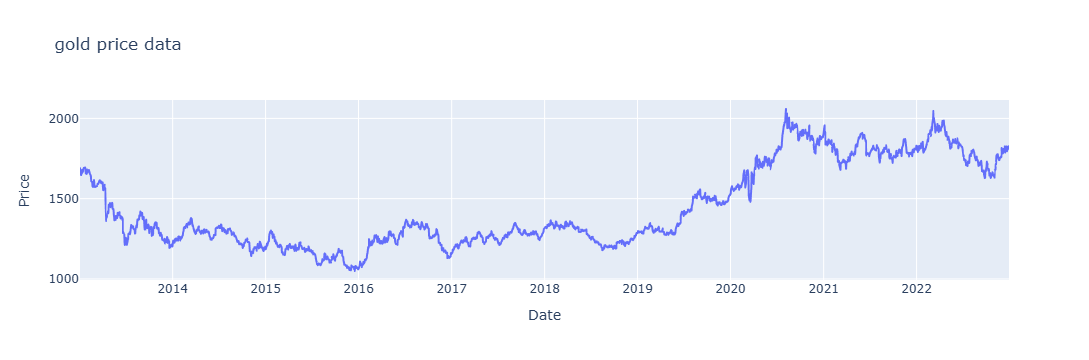

In [12]:
px.line(df, x='Date', y='Price', title='gold price data')

In [13]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price']])

In [14]:
test_size = len(df) - int(0.8 * len(df))
train_size = len(df) - test_size

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [15]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [16]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2006, 60, 1)
y_train shape: (2006, 1)
X_test shape: (517, 60, 1)
y_test shape: (517, 1)


In [17]:
# Build LSTM Model
input_layer = Input(shape=(seq_length, 1))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=True)(x)
# x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=True)(x)
# x = Dropout(0.2)(x)
# x = LSTM(64, return_sequences=True)(x)
# x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='nadam', loss='mse', metrics=['mse'])

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.001

In [20]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss[0]:.4f}')
print(f'Test MSE: {test_loss[1]:.4f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028 - mse: 0.0028
Test Loss: 0.0028
Test MSE: 0.0028


In [21]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions to original price scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(y_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred)
accuracy = (1 - mape) * 100

print(f'MAPE: {mape*100:.2f}%')
print(f'Accuracy: {accuracy:.2f}%')

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
MAPE: 2.43%
Accuracy: 97.57%


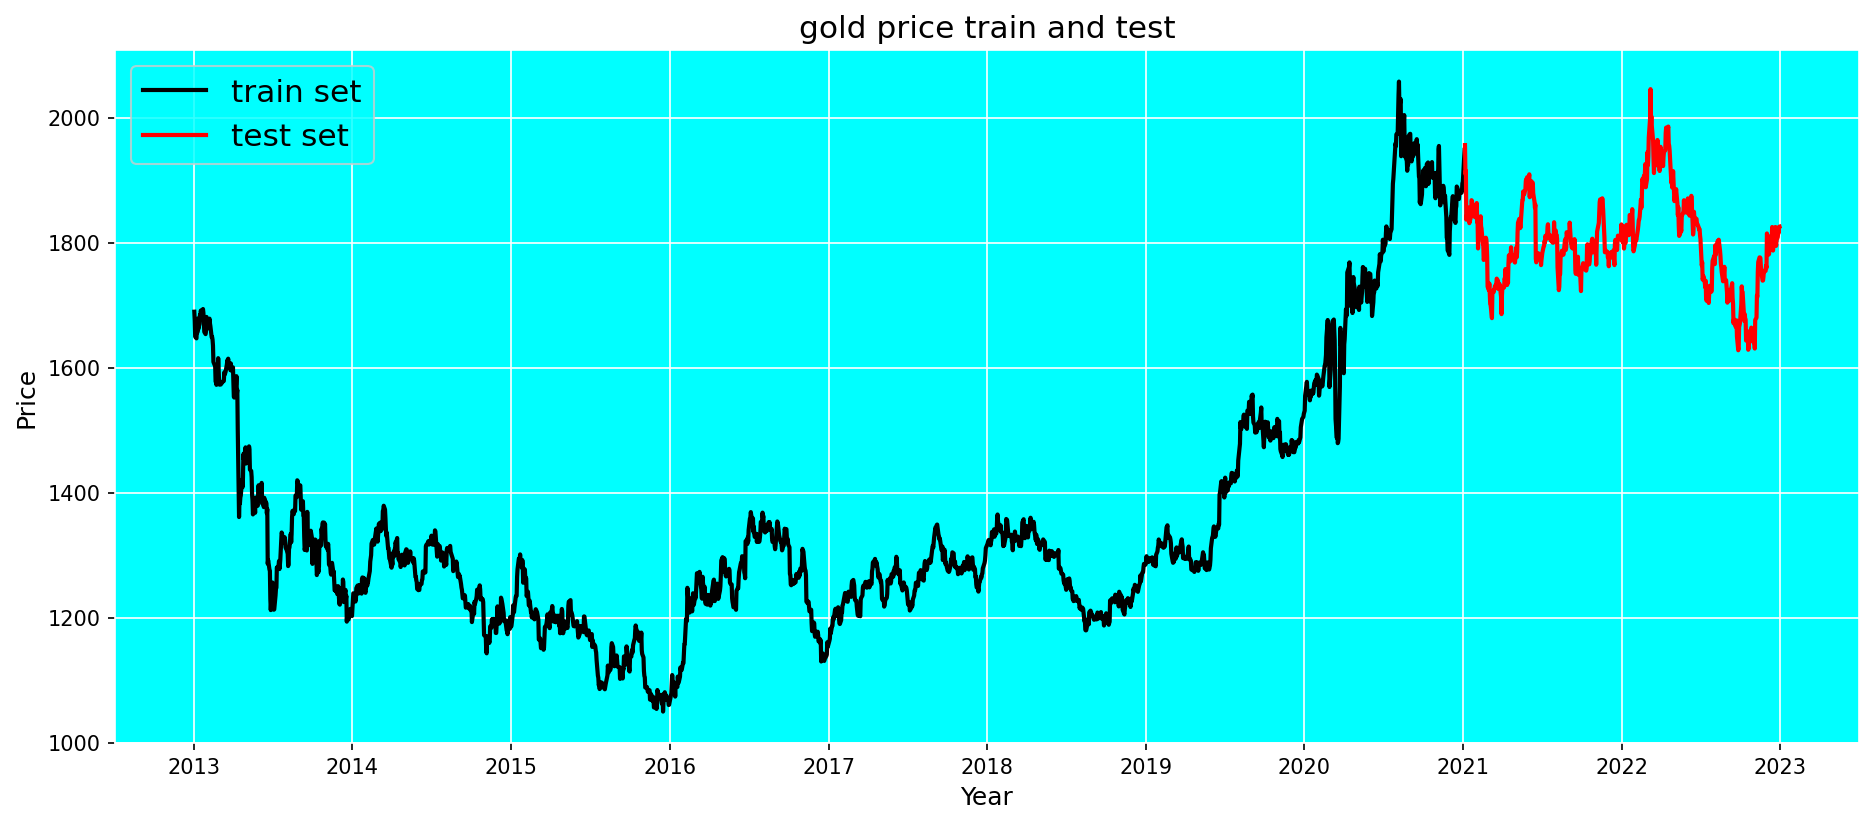

In [22]:
# Plot train and test split visualization
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'cyan'
plt.rc('axes', edgecolor='white')

plt.plot(df['Date'][:train_size], df['Price'][:train_size], color='black', lw=2)
plt.plot(df['Date'][train_size:], df['Price'][train_size:], color='red', lw=2)

plt.title('gold price train and test', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['train set', 'test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

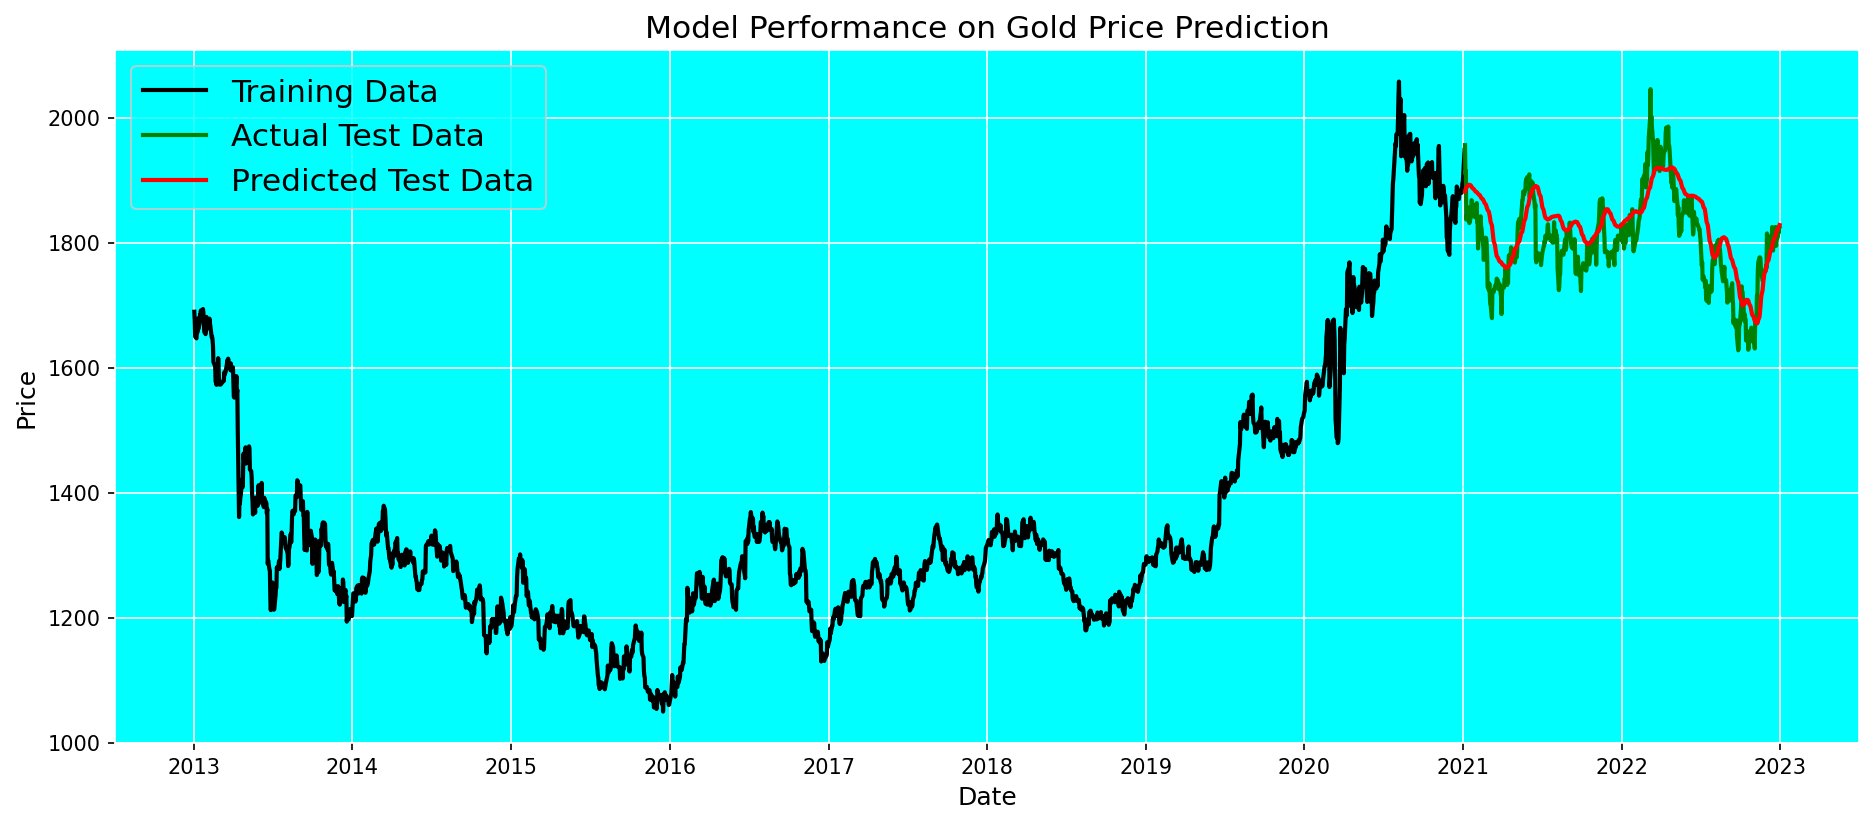


Model Performance Metrics:
MAPE: 2.43%
Accuracy: 97.57%

Prediction Samples:
Predicted Price Range: $1671.03 - $1921.17
Actual Price Range: $1628.20 - $2046.30


In [23]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'cyan'
plt.rc('axes', edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
y_test_true = y_test_unscaled
y_test_pred = y_pred
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color = 'green', lw = 2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color = 'red', lw = 2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

print(f'\nModel Performance Metrics:')
print(f'MAPE: {mape*100:.2f}%')
print(f'Accuracy: {accuracy:.2f}%')
print(f'\nPrediction Samples:')
print(f'Predicted Price Range: ${y_pred.min():.2f} - ${y_pred.max():.2f}')
print(f'Actual Price Range: ${y_test_unscaled.min():.2f} - ${y_test_unscaled.max():.2f}')